In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()

def show_plot(iteration,loss):

    plt.plot(iteration,loss)
    plt.show()

### Data preparation Class

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)


        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:

                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # img0 = img0.convert("L")
        # img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
folder_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/siamese_network/Cropped_images_b/train")

In [ ]:
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

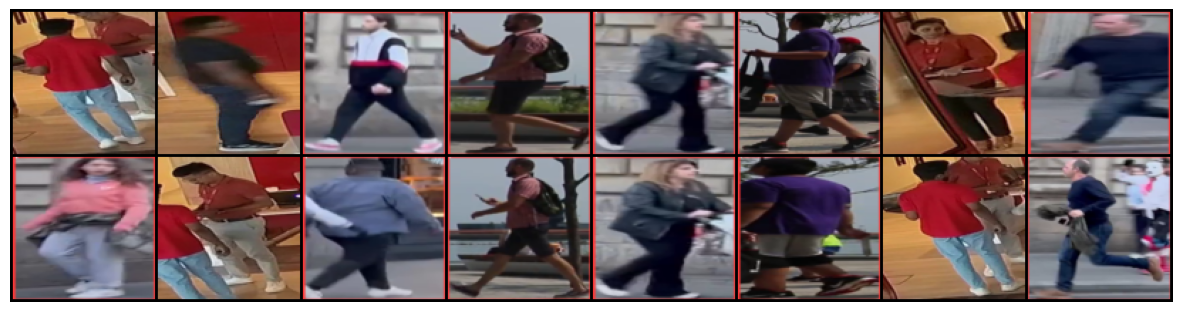

[1. 1. 1. 0. 0. 0. 1. 0.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

### Model creation

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=64)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 1.8076751232147217

Epoch number 0
 Current loss 0.8334448337554932

Epoch number 0
 Current loss 0.24543088674545288

Epoch number 1
 Current loss 0.31619536876678467

Epoch number 1
 Current loss 0.2887137830257416

Epoch number 1
 Current loss 0.18196548521518707

Epoch number 2
 Current loss 0.4017927646636963

Epoch number 2
 Current loss 0.16022704541683197

Epoch number 2
 Current loss 0.33574628829956055

Epoch number 3
 Current loss 0.28177082538604736

Epoch number 3
 Current loss 0.13123375177383423

Epoch number 3
 Current loss 0.21981070935726166

Epoch number 4
 Current loss 0.23403748869895935

Epoch number 4
 Current loss 0.14665353298187256

Epoch number 4
 Current loss 0.16232484579086304

Epoch number 5
 Current loss 0.13566844165325165

Epoch number 5
 Current loss 0.15143345296382904

Epoch number 5
 Current loss 0.24778757989406586

Epoch number 6
 Current loss 0.30772608518600464

Epoch number 6
 Current loss 0.1929253339767456

Epoch

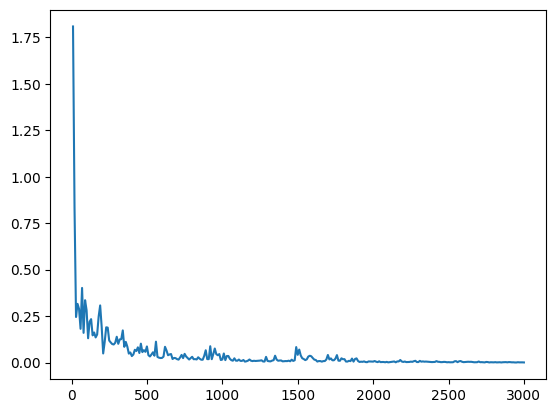

In [ ]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

In [ ]:
net.load_state_dict(torch.load('/content/drive/MyDrive/siamese_network/Cropped_images_b/model_100epochs/siamese_network_model_v2.pth'))

<All keys matched successfully>

### Testing the results

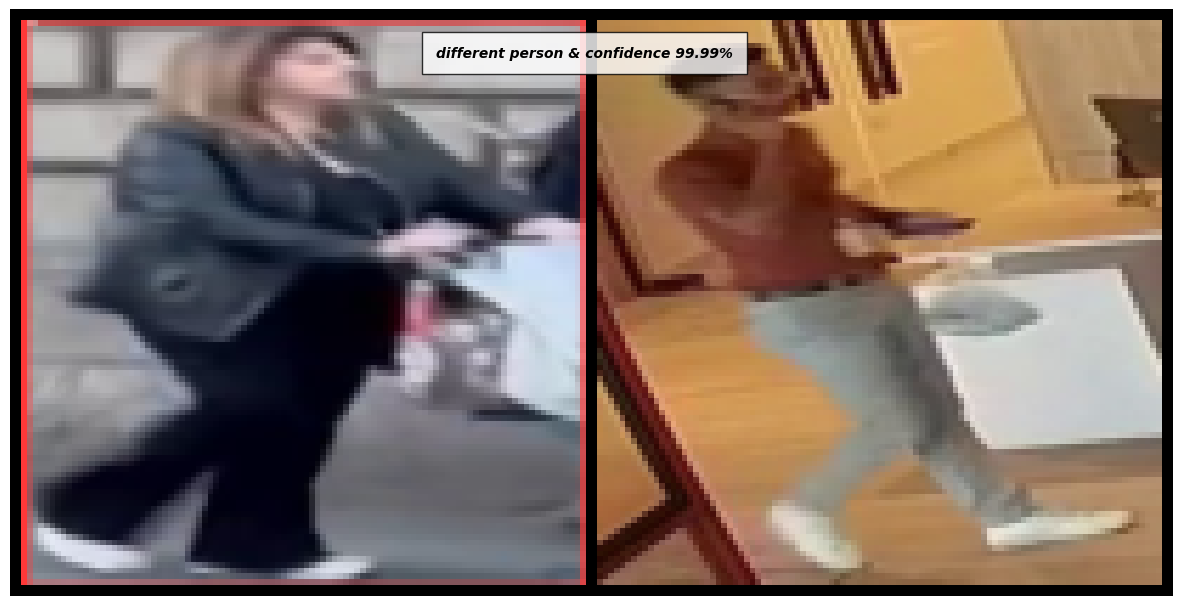

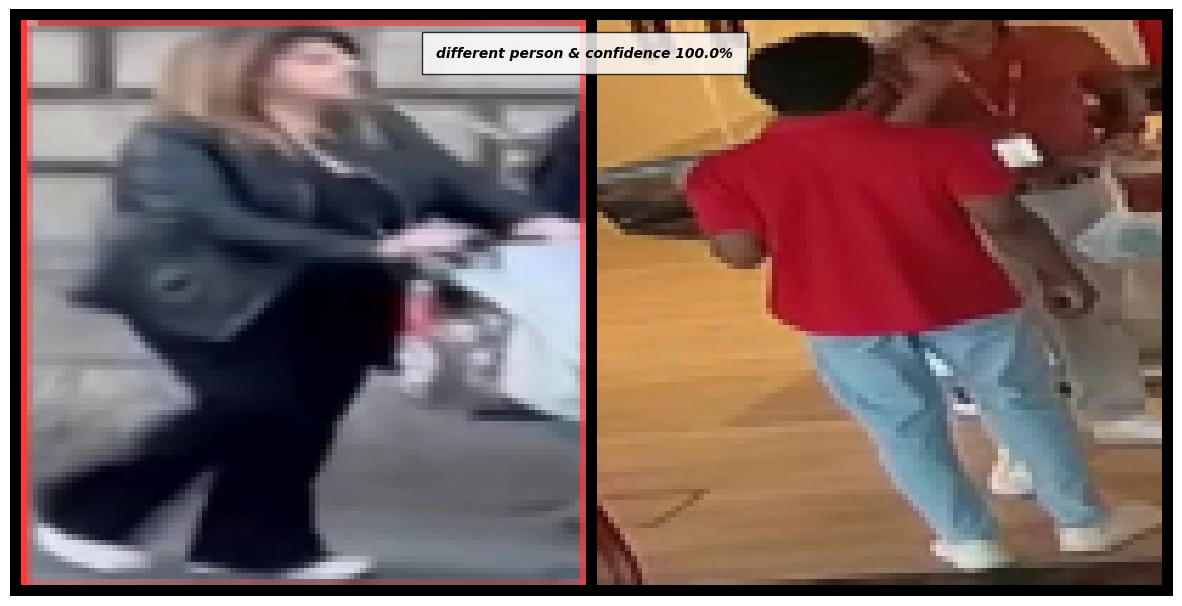

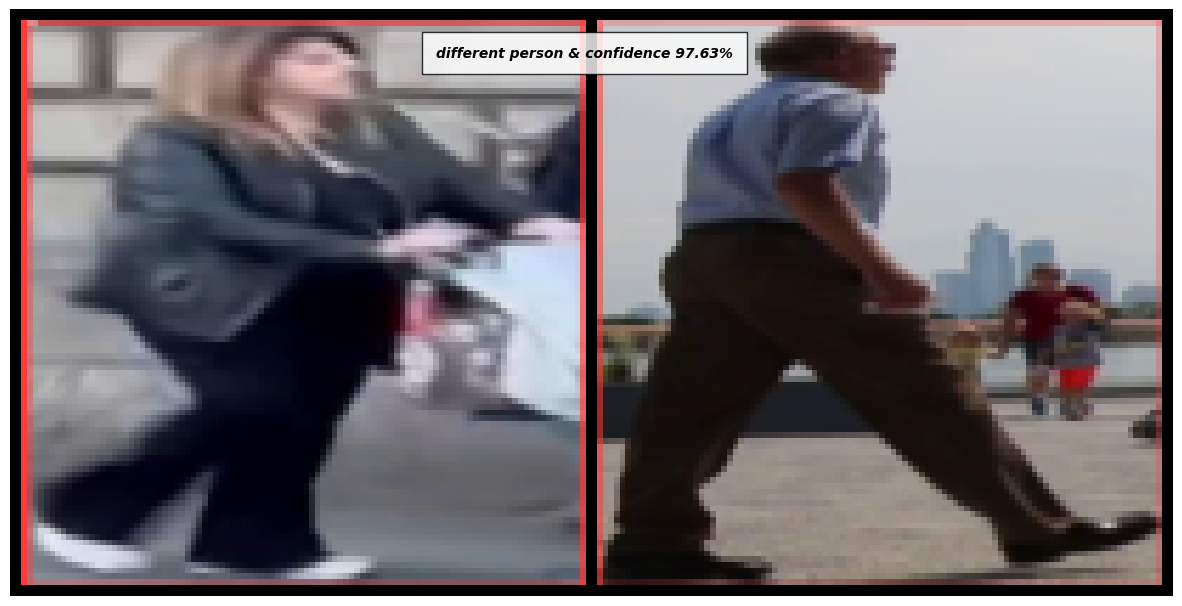

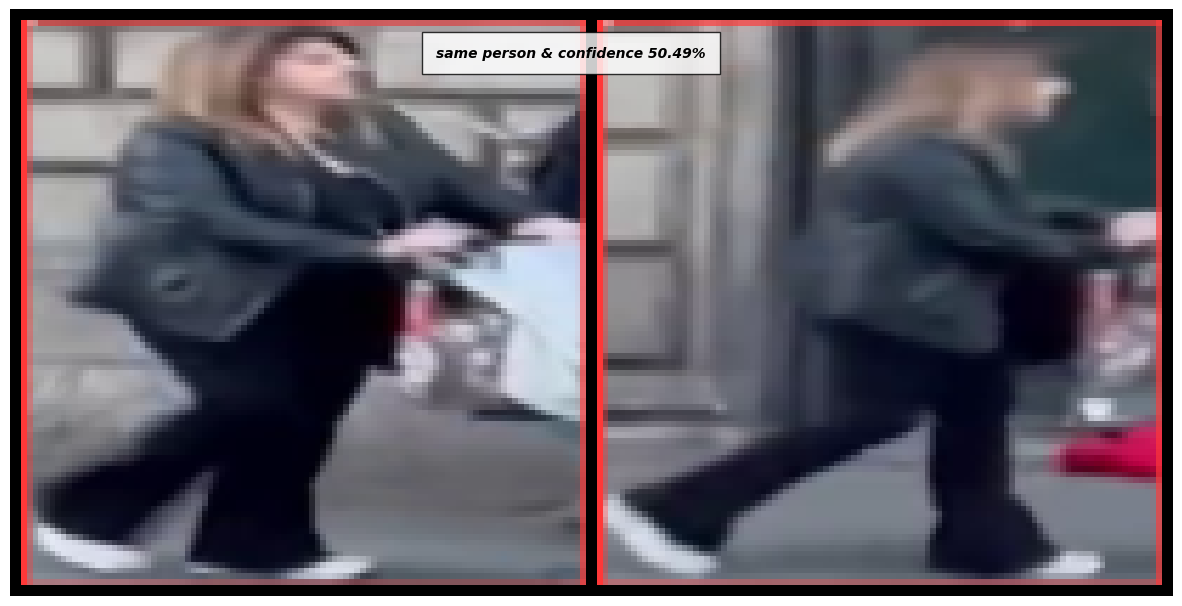

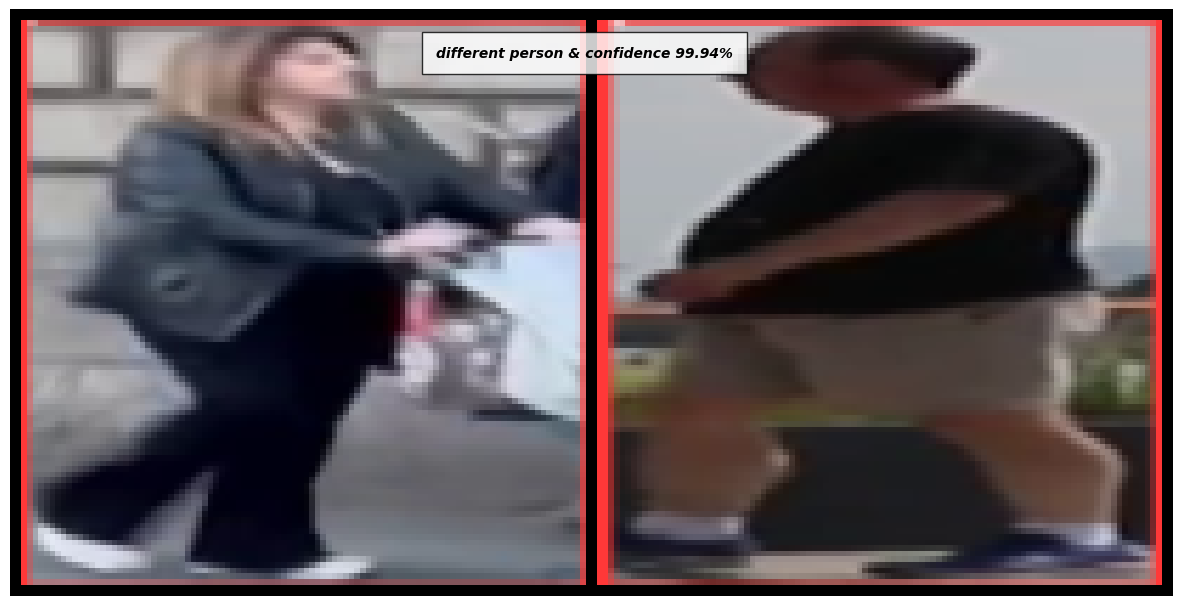

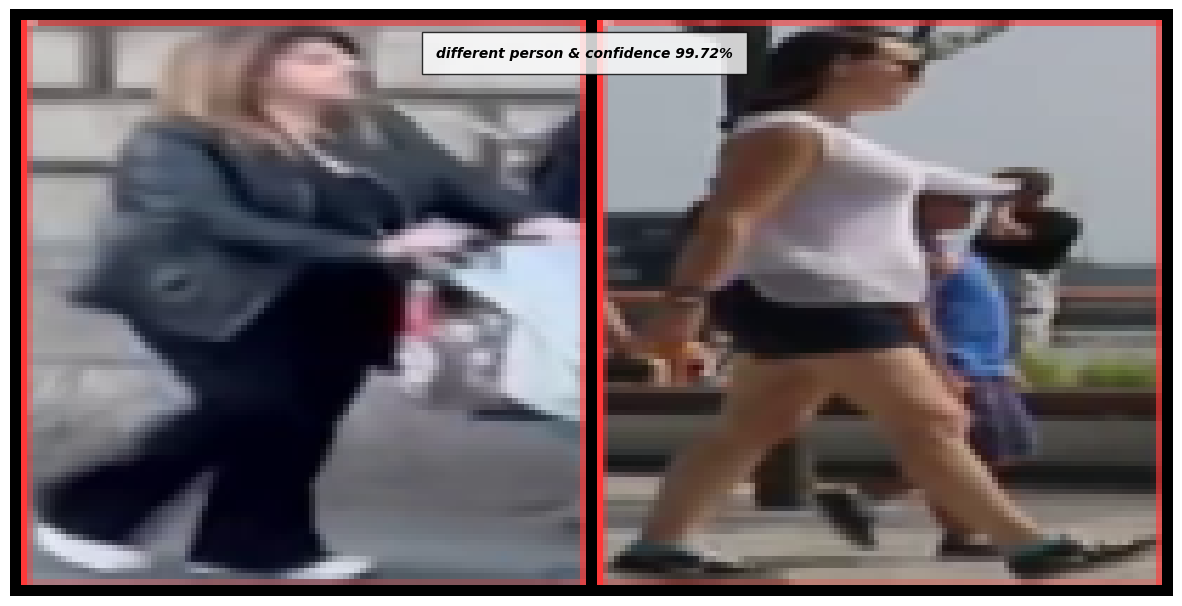

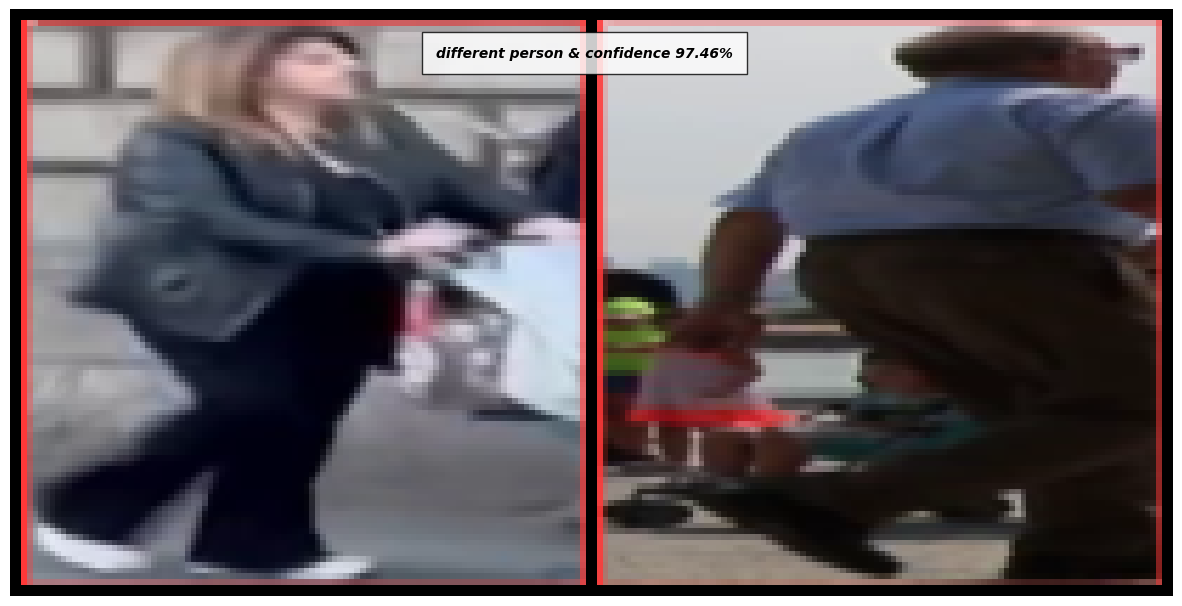

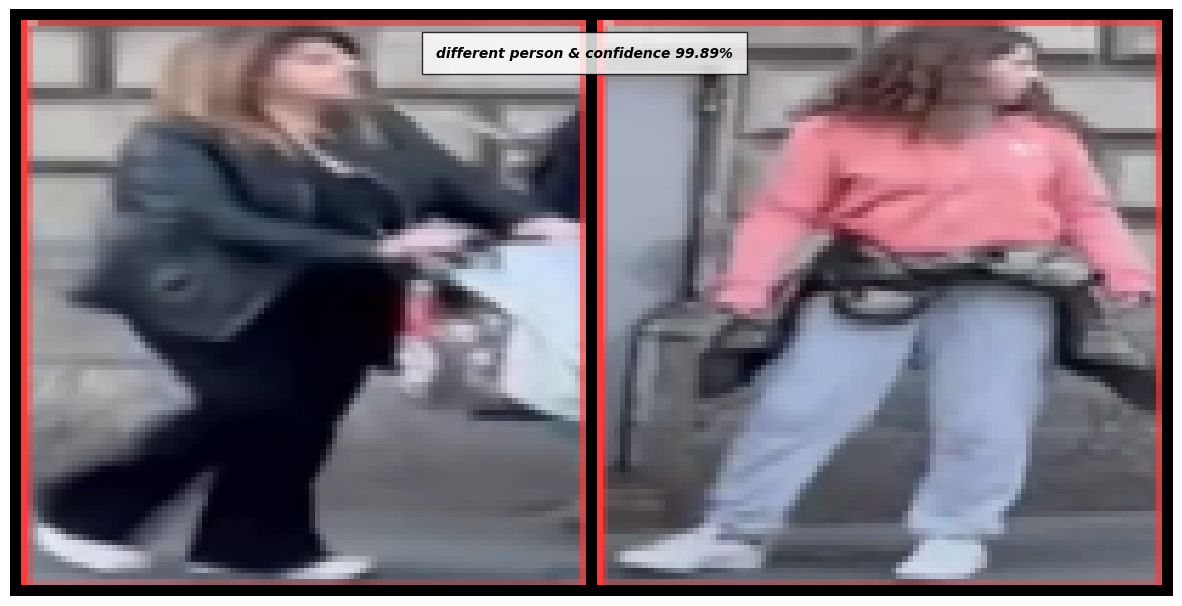

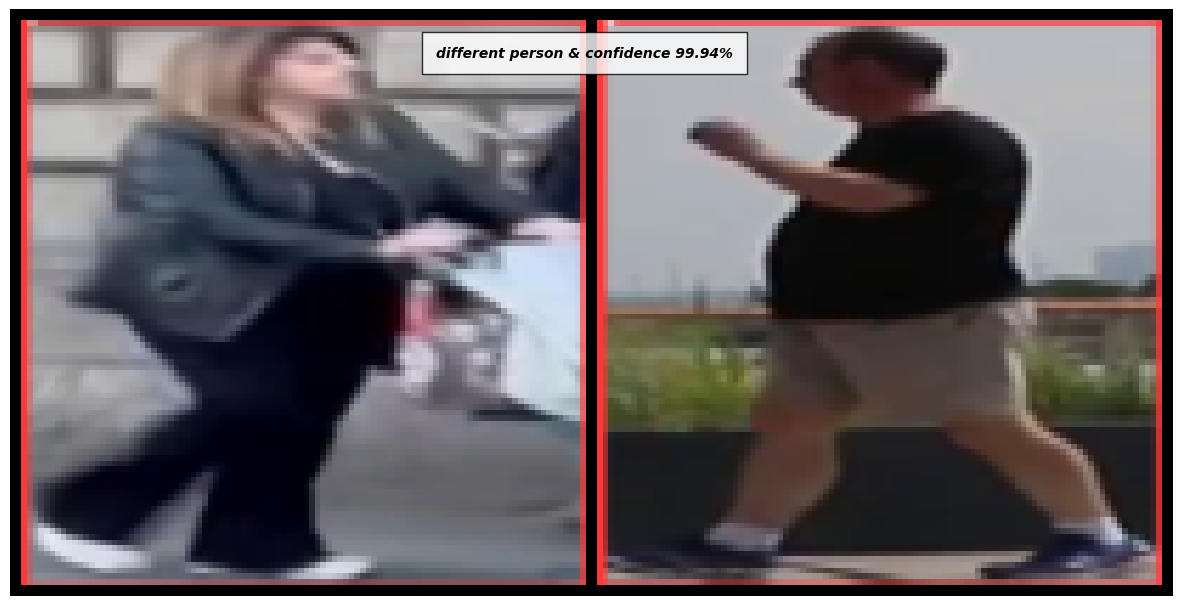

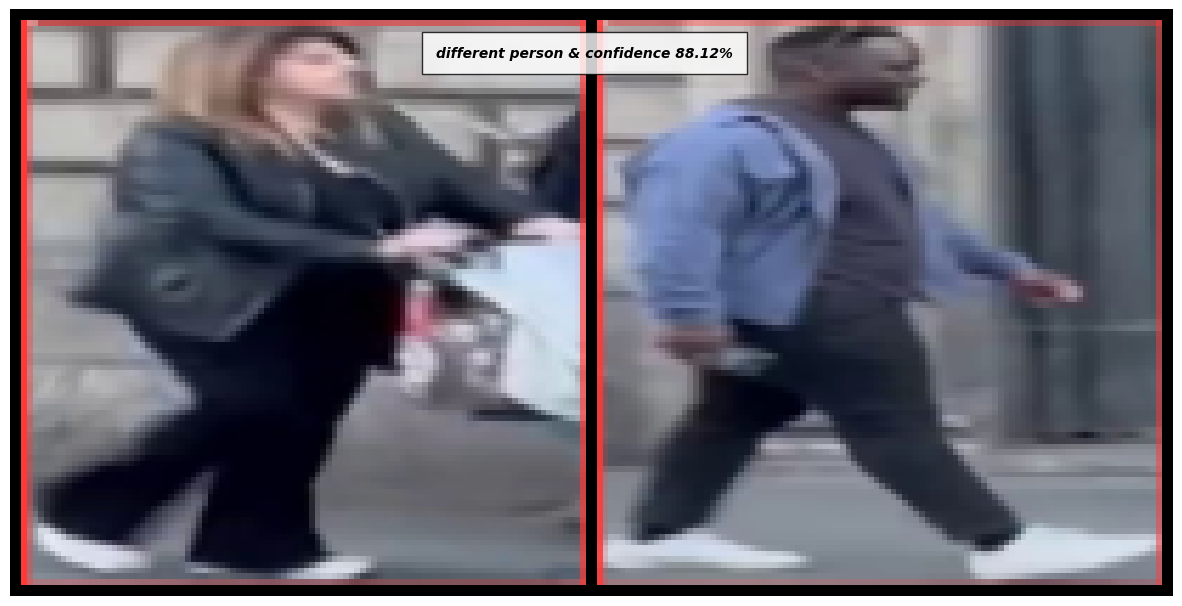

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="/content/drive/MyDrive/siamese_network/Cropped_images_b/train")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    # print(output1 , output2)
    # cosine_similarity = torch.nn.CosineSimilarity(dim=1)
    # print(cosine_similarity(output1 , output2))
    # similarity_score =   cosine_similarity(output1 , output2)
    euclidean_distance = F.pairwise_distance(output1, output2)
    sigmoid_output = torch.sigmoid(euclidean_distance)

    prediction = ''
    if euclidean_distance.item() < 1 :
      prediction = "same person"
    else:
      prediction = "different person"
    # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f} & {prediction} & {sigmoid_output.item()}')
    imshow(torchvision.utils.make_grid(concatenated), f'{prediction} & confidence {round(sigmoid_output.item()*100 ,2)}%')

In [ ]:
# Save the model
torch.save(net.state_dict(), '/content/drive/MyDrive/siamese_network/Cropped_images_b/model_100epochs/siamese_network_model_v2.pth')


### Run Inference


In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

# Load the pre-trained Siamese network model
net = SiameseNetwork()
net.load_state_dict(torch.load('/content/drive/MyDrive/siamese_network/Cropped_images_b/model_100epochs/siamese_network_model_v2.pth' , map_location=torch.device("cpu")))
net.eval()

# Image transformation
transformation = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

def get_image_similarity(image_path1, image_path2):
    """
    Compute the similarity between two images using the Siamese network.

    Args:
        image_path1 (str): File path of the first image.
        image_path2 (str): File path of the second image.

    Returns:
        float: Similarity score between the two images (1.0 for identical, 0.0 for completely different).
    """
    # Load and preprocess the images
    img1 = Image.open(image_path1)
    # img1 = transformation(img1).unsqueeze(0).cuda()
    img1 = transformation(img1).unsqueeze(0)

    img2 = Image.open(image_path2)
    # img2 = transformation(img2).unsqueeze(0).cuda()
    img2 = transformation(img2).unsqueeze(0)
    print(img2.shape)
    # Pass the images through the Siamese network
    output1, output2 = net(img1, img2)
    print(output1.shape)

    # Compute the Euclidean distance between the output vectors
    euclidean_distance = F.pairwise_distance(output1, output2)

    # Convert the distance to a similarity score
    similarity_score = torch.sigmoid(-euclidean_distance).item()

    return similarity_score

In [ ]:
image1_path = '/content/drive/MyDrive/siamese_network/Cropped_images_b/test/ID30/787.png'
image2_path = '/content/drive/MyDrive/siamese_network/Cropped_images_b/test/ID35/15.png'

similarity = get_image_similarity(image1_path, image2_path)
similarity = similarity*100
print(f'Similarity percentage: {similarity}%')

torch.Size([1, 3, 100, 100])
torch.Size([1, 2])
Similarity percentage: 0.5909771658480167%


### Convert to ONNX format

In [ ]:
!pip install onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.onnx


#define a dummy input

dummy_input1 = torch.randn(1, 3, 100, 100)
dummy_input2 = torch.randn(1, 3, 100, 100)

#export the model
torch.onnx.export(net, (dummy_input1, dummy_input2), "siamese_network.onnx", opset_version=11, input_names=['input1', 'input2'], output_names=['output1', 'output2'])



#### ONNX inference code

In [ ]:
import onnxruntime
import numpy as np
from PIL import Image

# Load the ONNX model
onnx_session = onnxruntime.InferenceSession("/content/drive/MyDrive/siamese_network/trained_model_weights/siamese_network.onnx")

# Image transformation
transformation = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

def get_image_similarity_onnx(image_path1, image_path2):
    """
    Compute the similarity between two images using the ONNX Siamese network model.

    Args:
        image_path1 (str): File path of the first image.
        image_path2 (str): File path of the second image.

    Returns:
        float: Similarity score between the two images (1.0 for identical, 0.0 for completely different).
    """
    # Load and preprocess the images
    img1 = Image.open(image_path1)
    img1 = transformation(img1).unsqueeze(0).numpy()

    img2 = Image.open(image_path2)
    img2 = transformation(img2).unsqueeze(0).numpy()

    # Run inference on the ONNX model
    outputs = onnx_session.run(None, {'input1': img1, 'input2': img2})
    output1, output2 = outputs

    # Compute the Euclidean distance between the output vectors
    euclidean_distance = np.linalg.norm(output1 - output2)

    # Convert the distance to a similarity score
    similarity_score = 1.0 / (1.0 + np.exp(euclidean_distance))

    return similarity_score

In [ ]:
image1_path = '/content/drive/MyDrive/siamese_network/Cropped_images_b/test/ID30/787.png'
image2_path = '/content/drive/MyDrive/siamese_network/Cropped_images_b/test/ID35/15.png'

similarity = get_image_similarity_onnx(image1_path, image2_path)
similarity = similarity*100
print(f'Similarity percentage: {similarity}%')

Similarity percentage: 0.5909755217138146%


In [ ]:
import onnxruntime
import numpy as np
from PIL import Image

# Load the ONNX model
onnx_session = onnxruntime.InferenceSession("/content/drive/MyDrive/siamese_network/trained_model_weights/siamese_network.onnx")

def resize_image(image, size):
    """
    Resize the image using NumPy.

    Args:
        image (numpy.ndarray): Input image as a NumPy array.
        size (tuple): Desired output size (height, width).

    Returns:
        numpy.ndarray: Resized image as a NumPy array.
    """
    pil_image = Image.fromarray(image)
    resized_pil_image = pil_image.resize(size[::-1], resample=Image.BILINEAR)
    resized_image = np.array(resized_pil_image)
    return resized_image

def to_tensor(image):
    """
    Convert the image to a PyTorch tensor.

    Args:
        image (numpy.ndarray): Input image as a NumPy array.

    Returns:
        numpy.ndarray: Image tensor.
    """
    return np.transpose(image, (2, 0, 1)).astype(np.float32) / 255.0

def get_image_similarity_onnx_numpy(image_path1, image_path2):
    """
    Compute the similarity between two images using the ONNX Siamese network model.

    Args:
        image_path1 (str): File path of the first image.
        image_path2 (str): File path of the second image.

    Returns:
        float: Similarity score between the two images (1.0 for identical, 0.0 for completely different).
    """
    # Load and preprocess the images
    img1 = np.array(Image.open(image_path1))
    img1 = resize_image(img1, (100, 100))
    img1 = to_tensor(img1)
    img1 = np.expand_dims(img1, axis=0)
    print("hello there ")
    img2 = np.array(Image.open(image_path2))
    img2 = resize_image(img2, (100, 100))
    img2 = to_tensor(img2)
    img2 = np.expand_dims(img2, axis=0)

    # Run inference on the ONNX model
    outputs = onnx_session.run(None, {'input1': img1, 'input2': img2})
    output1, output2 = outputs

    # Compute the Euclidean distance between the output vectors
    euclidean_distance = np.linalg.norm(output1 - output2)

    # Convert the distance to a similarity score
    similarity_score = 1.0 / (1.0 + np.exp(euclidean_distance))

    return similarity_score


In [ ]:
image1_path = '/content/drive/MyDrive/siamese_network/Cropped_images_b/test/ID30/787.png'
image2_path = '/content/drive/MyDrive/siamese_network/Cropped_images_b/test/ID35/15.png'

similarity = get_image_similarity_onnx_numpy(image1_path, image2_path)
similarity = similarity*100
print(f'Similarity percentage: {similarity}%')

hello there 
Similarity percentage: 0.5909755217138146%


move onnx model to drive

In [ ]:
import shutil

def move_file(source, destination):
    try:
        shutil.move(source, destination)
        print(f"File moved successfully from {source} to {destination}")
    except FileNotFoundError:
        print("File not found.")
    except PermissionError:
        print("Permission denied. Make sure you have necessary permissions.")


source_file = "/content/siamese_network.onnx"
destination_file = "/content/drive/MyDrive/siamese_network/trained_model_weights"
move_file(source_file, destination_file)


File moved successfully from /content/siamese_network.onnx to /content/drive/MyDrive/siamese_network/trained_model_weights
